In [1]:
from helpers.helper_functions import read_and_set_df, pd, np, msno, go, plt, sns, px, tf

In [2]:
X_train = pd.read_csv('data/x_train_clean.csv', sep='$', decimal=".", engine='python') 
y_train = pd.read_csv('data/y_train_clean.csv', sep='$', decimal=".", engine='python')   
X_test = pd.read_csv('data/x_test_clean.csv', sep='$', decimal=".", engine='python') 
y_test = pd.read_csv('data/y_test_clean.csv', sep='$', decimal=".", engine='python') 

del X_train['Unnamed: 0']
del y_train['Unnamed: 0']
del X_test['Unnamed: 0']
del y_test['Unnamed: 0']
len(X_train)

4604

In [39]:
# Pakete für den Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, make_scorer, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score      #, cumulative
import json


from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials , space_eval
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

## Random Forest Classifier Train Set

In [4]:
def get_auc_pr(y_test_df, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_test_df, y_proba)
    return auc(recall, precision)

# grater_is_better = höhere Werte sind besser - keine loss function 
scorer_auc_pr = make_scorer(get_auc_pr, greater_is_better = True, needs_proba=True)


def create_random_forest_model(X_train, y_train):

    # Hyperparameter-Tuning definieren
    rf_classifier = RandomForestClassifier(random_state = 42, n_jobs = -1, class_weight='balanced_subsample')

    # Intervalle für das Tuning festlegen
    params = {
        'n_estimators': [250, 500, 1000, 1500],                              #250, 500, 1000, 1500
        'max_depth': [5, 10, 50, 100, 200, None],                    #5, 10, 20, 30, 50, 100, 200, None
        'min_samples_split': [2, .1,.5], 
        'min_samples_leaf': [1 , 3, 9],
        'max_features': [.01, .05, .05, 'log2', "sqrt", 'auto']
    }

    cv = RandomizedSearchCV(rf_classifier,
                            params,
                            n_iter = 1000,                                     #1000
                            scoring= make_scorer,
                            cv = 5,                                            #5
                            n_jobs = -1,
                            random_state = 42)
    

    # Tuning durchführen 
    print('Starte Hyperparameter-Tuning')
    cv.fit(X_train, y_train)
    print('Tuning beendet')

    print(cv.best_params_)
    best_params = cv.best_params_
    model_rf = cv.best_estimator_

    # Ergebnisse speichern
    file_name = './data/random_forest' 
    with open(file_name + '_params.json', 'w') as outfile:
        json.dump(best_params, outfile, indent = 4)
    
    return model_rf 

In [6]:
def get_auc_pr(y_train, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_train, y_proba)
    return auc(recall, precision)

# grater_is_better = höhere Werte sind besser - keine loss function 
scorer_auc_pr = make_scorer(get_auc_pr, greater_is_better = True, needs_proba=True)

def hyperopt_train_test(params):
        clf = RandomForestClassifier(**params)
        cv = cross_val_score(clf, X_train, y_train['response'], scoring=scorer_auc_pr, cv=5).mean()
        return cv
    
space = {'max_depth': hp.choice('max_depth', range(1,20)),
         'max_features': hp.choice('max_features', range(1,5)),
         'n_estimators': hp.choice('n_estimators', range(1,20)),
         'min_samples_split': hp.choice('min_samples_split', range(2, 5)),
         'max_leaf_nodes': hp.choice('max_leaf_nodes', range(2, 5)), 
         'criterion': hp.choice('criterion', ["gini", "entropy"])}

best = 0

def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
    print('new best:', best, params)
    # We aim to maximize accuracy, therefore we return it as a negativve value
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
# fmin = fine tuning the model and then print the best lost with its hyperparameters values
best = fmin(f,
            space,
            algo=tpe.suggest,
            max_evals=300, trials=trials)
            
print('best:')
print(best)

new best:                                              
0.8744098692319527                                     
{'criterion': 'gini', 'max_depth': 8, 'max_features': 3, 'max_leaf_nodes': 2, 'min_samples_split': 2, 'n_estimators': 18}
new best:                                                                         
0.8813339542450324                                                                
{'criterion': 'entropy', 'max_depth': 2, 'max_features': 4, 'max_leaf_nodes': 4, 'min_samples_split': 3, 'n_estimators': 18}
new best:                                                                         
0.8813339542450324                                                                
{'criterion': 'gini', 'max_depth': 16, 'max_features': 1, 'max_leaf_nodes': 2, 'min_samples_split': 3, 'n_estimators': 3}
new best:                                                                         
0.8813339542450324                                                                
{'criterion': 'entrop

In [7]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
# Show best model
print(space_eval(space, best))

{'criterion': 'gini', 'max_depth': 9, 'max_features': 4, 'max_leaf_nodes': 4, 'min_samples_split': 3, 'n_estimators': 17}


In [8]:
# training final classifier
clf = RandomForestClassifier(max_depth= 19,
                             max_features=1,
                             max_leaf_nodes=4,
                             min_samples_split=2,
                             n_estimators=19,
                             random_state=42)

fit_rf = clf.fit(X_train, y_train['response'])
y_pred_proba = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

print(y_pred)
print(y_pred_proba)

[0 1 0 ... 1 1 1]
[0.22632806 0.70199296 0.42973251 ... 0.71607639 0.57902896 0.72491685]


In [9]:
# Funktion für den pr_auc schreiben
def get_auc_pr(y_test, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    return auc(recall, precision)

# pr_auc ausgeben lassen
pr_auc_rf = get_auc_pr(y_test[['response']], y_pred)
print(pr_auc_rf)

0.8656805212326261


# Evaluation 

#### Entscheidung für ein Gütemaß

Accuracy:  Die Accuracy wird anhand der vorhergesagten Klassen berechnet. Das bedeutet, dass sie auch den verwendeten Threshold beinhaltet, der zunächst noch optimiert werden muss. 

ROC-AUC und PR-AUC:
Der roc_auc und der pr_auc betrachten beide die Vorhersagewerte von Klassifizierungsmodellen und nicht die Klassenzuordnungen mit Schwellwerten. Der Unterschied besteht jedoch darin, dass roc_auc den Anteil der wahren Positiven (TPR) und den Anteil der falschen Positiven (FPR) berücksichtigt, während der pr_auc den positiven Vorhersagewert (PPV) und den Anteil der wahren Positiven (TPR) berücksichtigt. Da wir in unserem Fall mehr Fokus auf die positive Klasse legen, ist die Verwendung des pr_auc, der empfindlicher auf Verbesserungen für die positive Klasse reagiert, die bessere Wahl.

Darum werden wir als maßgebliches Gütemaß den pr_auc in diesem Anwendungsfall verwenden.

#### Visuelle Darstellung der Confusion Matrix

<AxesSubplot:>

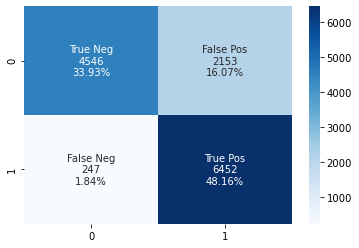

In [10]:
# Konfusionsmatrix
cf_matrix = confusion_matrix(y_test[['response']], y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]


labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#### Feature Importance 

In [43]:
# Feature Importance für den Trainingsdatensatz plotten

#Feature Importance in einem Data Frame ablegen und absteigend nach den höchsten Werten sortieren 
feature_importances=pd.DataFrame({'features':X_train.columns,'feature_importance':fit_rf.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

# Bar Chart erstellen 
fig = go.Figure(go.Bar(
            x=feature_importances['feature_importance'].sort_values(ascending=True),
            y=X_train.columns,
            text=round(feature_importances['feature_importance'].sort_values(ascending=True), 2),
            marker_color= 'rgb(18,116,117)',
            orientation='h'))

fig.update_traces(textposition='outside')
fig.update_layout(title_text = 'Feature Importance')
fig.show()

#### ROC Kurve

In [12]:
fpr, tpr, _ = roc_curve(y_test['response'], y_pred_proba)
auc_score = roc_auc_score(y_test['response'], y_pred_proba)


fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC-Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)


fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)


fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

#### Precision-Recall-Curve

Der `Recall` sagt also etwas darüber aus, wieviele der in der Datenbank vorhandenen relevanten Dokumente gefunden wurden – ins Verhältnis gesetzt zur Anzahl aller relevanten Dokumente in der Datenbank. 

Die `Precision` setzt jene Zahl ins Verhältnis zur Zahl der insgesamt gefundenen Dokumente, sie gibt an, wieviele der gefundenen relevant sind. Grob gesprochen: Recall – wieviel habe ich gefunden, wieviel Substanz hat die Datenbank ; Precision – wieviel Unbrauchbares habe ich gefunden, wie genau kann man in der Datenbank suchen?

In [13]:
# Muss noch angepasst werden 
tpr, fpr, thresholds = roc_curve(y_test['response'], y_pred_proba)
precision_recall_threshold = pd.DataFrame(precision_recall_curve(y_test[['response']], y_pred_proba)).transpose()
precision_recall_threshold.columns = ['Precision', 'Recall', 'Threshold']

fig = px.area(
    x=precision_recall_threshold['Recall'], y=precision_recall_threshold['Precision'],
    title=f'Precision-Recall Curve (AUC={pr_auc_rf:.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

#### Precision-Recall-Threshold Curve

In [14]:
# Data Frame erzeugen, der die precision, recall, threshold werte enthält 
precision_recall_threshold = np.transpose(pd.DataFrame(precision_recall_curve(y_test[['response']], y_pred_proba)))
precision_recall_threshold.columns = ['Precision', 'Recall', 'Threshold']

# Schnittpunkt von Precision und Threshold berechnen und den dazugehörigen Threshold in einem Data Frame ablegen 
precision_recall_threshold['distance']  =  abs(precision_recall_threshold['Precision'] - precision_recall_threshold['Recall'])
intersection_precision_recall_threshold = precision_recall_threshold.loc[precision_recall_threshold['distance'] == precision_recall_threshold['distance'].min()]
intersection = intersection_precision_recall_threshold['Threshold']


# Plot erzeugen 
fig = go.Figure()

# Trace für die Precison und die dazugehörigen Thresholds
fig.add_trace(go.Scatter(x=precision_recall_threshold['Threshold'], y=precision_recall_threshold['Precision'],
                    fill='tozeroy', fillcolor='rgba(248, 118, 109, 0.5)', opacity=0.5,
                    hoveron = 'points+fills', # select where hover is active
                    line_color='rgba(248, 118, 109, 0.5)',
                    name= 'Precision',
                    hoverinfo = 'text+x+y'))


# Trace für den Recall und die dazugehörigen Thresholds
fig.add_trace(go.Scatter(x=precision_recall_threshold['Threshold'], y=precision_recall_threshold['Recall'],
                    fill='tozeroy', fillcolor = 'rgba(0, 191, 196, 0.5)',
                    hoveron='points',
                    line_color='rgba(0, 191, 196, 0.5)',
                    name= 'Recall',
                    hoverinfo='text+x+y')) 


# Schnittpunkt von Precision und Recall einfügen
fig.add_traces(go.Scatter(
    x= [intersection.values[0],intersection.values[0]],
    y=[0,1],
    mode='lines',
    name=f'threshold {intersection.values[0]:.4f}',
    line={'dash': 'dash', 
          'color': 'silver',
          'width': 2}
    ))


# Layout anpoassen
fig.update_layout(title = f'Precision-Recall-Threshold Curve (AUC={pr_auc_rf:.4f})')
fig.update_layout(hovermode='x unified')
fig.update_xaxes(title_text='Threshold')
fig.update_yaxes(title_text='Precision / Recall')

fig.show()

#### Sensitivity-Specificity-Threshold Curve

In [38]:
fpr, tpr, thresholds =roc_curve(y_test[['response']], y_pred_proba)
sensitivity_specificity_threshold = pd.DataFrame({'Sensitivity' : tpr,'Specificitiy' : 1 - fpr, 'Threshold': thresholds})

# Es war ein Threshold mit dem Wert von 1,7 drin - Den habe ich gelöscht, da der plot sonst extrem verzerrt wird
sensitivity_specificity_threshold = sensitivity_specificity_threshold.iloc[1: , :]

# Schnittpunkt von Precision und Threshold berechnen und den dazugehörigen Threshold in einem Data Frame ablegen 
sensitivity_specificity_threshold['distance']  =  abs(sensitivity_specificity_threshold['Sensitivity'] - sensitivity_specificity_threshold['Specificitiy'])
intersection_specificity_threshold = sensitivity_specificity_threshold.loc[sensitivity_specificity_threshold['distance'] == sensitivity_specificity_threshold['distance'].min()]
intersection_spt = intersection_specificity_threshold['Threshold']


# Plot erzeugen 
fig = go.Figure()

# Trace für die Precison und die dazugehörigen Thresholds
fig.add_trace(go.Scatter(x=sensitivity_specificity_threshold['Threshold'], y=sensitivity_specificity_threshold['Sensitivity'],
                    fill='tozeroy', fillcolor='rgba(248, 118, 109, 0.5)', opacity=0.5,
                    hoveron = 'points+fills', # select where hover is active
                    line_color='rgba(248, 118, 109, 0.5)',
                    name= 'Sensitivity',
                    hoverinfo = 'text+x+y'))


# Trace für den Recall und die dazugehörigen Thresholds
fig.add_trace(go.Scatter(x=sensitivity_specificity_threshold['Threshold'], y=sensitivity_specificity_threshold['Specificitiy'],
                    fill='tozeroy', fillcolor = 'rgba(0, 191, 196, 0.5)',
                    hoveron='points',
                    line_color='rgba(0, 191, 196, 0.5)',
                    name= 'Specificitiy',
                    hoverinfo='text+x+y')) 


# Schnittpunkt von Precision und Recall einfügen
fig.add_traces(go.Scatter(
    x= [intersection_spt.values[0],intersection_spt.values[0]],
    y=[0,1],
    mode='lines',
    name=f'threshold {intersection_spt.values[0]:.4f}',
    line={'dash': 'dash', 
          'color': 'silver',
          'width': 2}
    ))


# Layout anpoassen
fig.update_layout(title = 'Sensitivity-Specificity-Threshold Curve')
fig.update_layout(hovermode='x unified')
fig.update_xaxes(title_text='Threshold')
fig.update_yaxes(title_text='Sensitivity / Specificity')

fig.show()

#### Cumulative Gain Chart

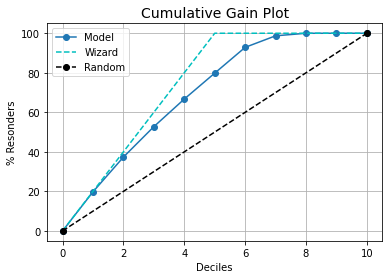

In [17]:
import kds
kds.metrics.plot_cumulative_gain(np.array(y_test['response']), y_pred_proba)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.722,0.744,0.728,1340.0,1324.0,16.0,669.9,1340,98.806,1340.0,1324.0,1340,16.0,10.001,19.764,20.003,0.239,19.525,1.976
1,2,0.709,0.722,0.715,1340.0,1178.0,162.0,669.9,1340,87.910,2680.0,2502.0,2680,178.0,20.003,37.349,40.006,2.657,34.692,1.867
2,3,0.700,0.709,0.704,1340.0,1031.0,309.0,669.9,1340,76.940,4020.0,3533.0,4020,487.0,30.004,52.739,60.009,7.270,45.469,1.758
3,4,0.665,0.700,0.687,1340.0,936.0,404.0,669.9,1340,69.851,5360.0,4469.0,5360,891.0,40.006,66.711,80.012,13.300,53.411,1.668
4,5,0.596,0.665,0.630,1339.0,878.0,461.0,669.9,1339,65.571,6699.0,5347.0,6699,1352.0,50.000,79.818,100.000,20.182,59.636,1.596
5,6,0.555,0.596,0.579,1340.0,874.0,466.0,669.9,0,65.224,8039.0,6221.0,6699,1818.0,60.001,92.865,100.000,27.138,65.727,1.548
6,7,0.385,0.555,0.482,1340.0,391.0,949.0,669.9,0,29.179,9379.0,6612.0,6699,2767.0,70.003,98.701,100.000,41.305,57.396,1.410
7,8,0.203,0.385,0.286,1340.0,86.0,1254.0,669.9,0,6.418,10719.0,6698.0,6699,4021.0,80.004,99.985,100.000,60.024,39.961,1.250
8,9,0.109,0.203,0.158,1340.0,1.0,1339.0,669.9,0,0.075,12059.0,6699.0,6699,5360.0,90.006,100.000,100.000,80.012,19.988,1.111
9,10,0.068,0.109,0.082,1339.0,0.0,1339.0,669.9,0,0.000,13398.0,6699.0,6699,6699.0,100.000,100.000,100.000,100.000,0.000,1.000


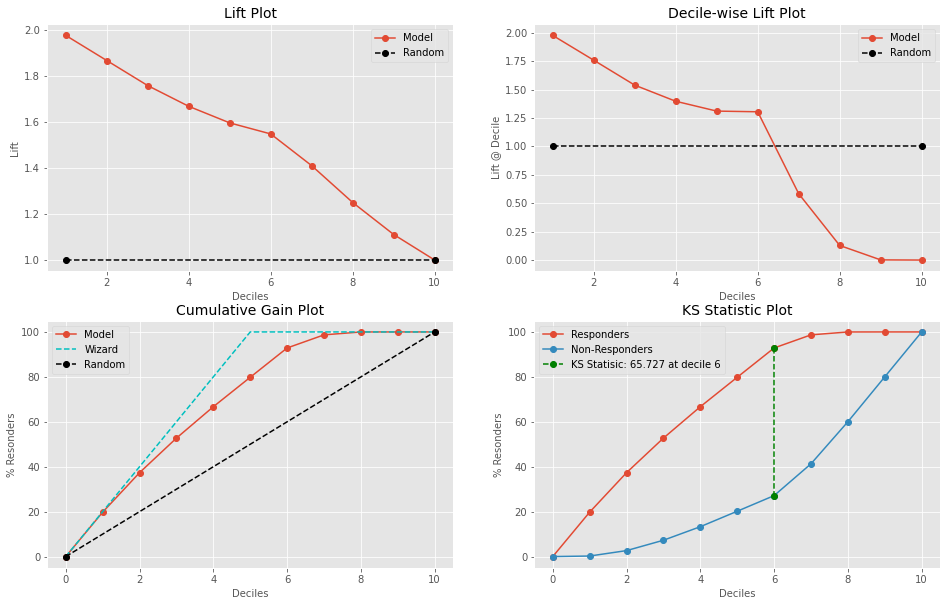

In [18]:
kds.metrics.report(np.array(y_test['response']), y_pred_proba,plot_style='ggplot')

In [19]:
X_test['predicted_probability'] = clf.predict_proba(X_test)[:,1] # Predicted Proba for bads(=1)
X_test['Risk'] = y_test #Ground Truth
X_test.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,predicted_probability,Risk
0,1.0,29.0,1.0,46.0,1.0,0.0,0.0,27514.0,151.0,200.0,0.226328,0
1,1.0,42.0,0.0,23.0,0.0,1.0,1.0,31795.0,124.0,82.0,0.701993,0
2,0.0,31.0,0.0,28.0,0.0,0.0,1.0,57616.0,163.0,81.0,0.429733,0
3,0.0,22.0,0.0,8.0,0.0,0.0,1.0,39030.0,124.0,118.0,0.408403,0
4,0.0,47.0,1.0,28.0,1.0,1.0,0.0,41432.0,26.0,32.0,0.261460,0


In [20]:
#Sort the data in descending order of predicted probabilities.
X_test = X_test.sort_values(by='predicted_probability', ascending=False)
X_test.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,predicted_probability,Risk
8491,0.585432,50.148407,0.0,19.708650,0.0,0.585432,1.0,57925.619421,42.977542,209.770560,0.744189,1
12116,0.092453,37.075465,0.0,25.688663,0.0,0.907547,1.0,57128.621049,35.060440,169.245347,0.744189,1
11638,0.590849,36.865383,0.0,28.000000,0.0,0.409151,1.0,53265.793129,124.000000,79.816977,0.744189,1
8687,0.756488,30.844298,0.0,28.000000,0.0,0.487025,1.0,53325.932392,100.135784,133.293308,0.744189,1
12296,0.217613,35.823872,0.0,22.559680,0.0,0.782387,1.0,57186.319503,47.326055,181.761280,0.744189,1


In [21]:
#Cut deciles based on the predicted probabilities
X_test['decile_group'] = pd.qcut(X_test['predicted_probability'], 10)
X_test.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,predicted_probability,Risk,decile_group
8491,0.585432,50.148407,0.0,19.708650,0.0,0.585432,1.0,57925.619421,42.977542,209.770560,0.744189,1,"(0.722, 0.744]"
12116,0.092453,37.075465,0.0,25.688663,0.0,0.907547,1.0,57128.621049,35.060440,169.245347,0.744189,1,"(0.722, 0.744]"
11638,0.590849,36.865383,0.0,28.000000,0.0,0.409151,1.0,53265.793129,124.000000,79.816977,0.744189,1,"(0.722, 0.744]"
8687,0.756488,30.844298,0.0,28.000000,0.0,0.487025,1.0,53325.932392,100.135784,133.293308,0.744189,1,"(0.722, 0.744]"
12296,0.217613,35.823872,0.0,22.559680,0.0,0.782387,1.0,57186.319503,47.326055,181.761280,0.744189,1,"(0.722, 0.744]"


In [22]:
lift = X_test.groupby('decile_group').agg( #Group by Deciles of Predicted Probabilties
[
    'count', #The total number of customers(data points) in the decile
    'sum', #The total number of bad customers(Risk=1)
]
)['Risk'].sort_index(ascending=False)
lift.columns = ['Number of customers','Number of goods']
lift['Cumulative goods'] = lift['Number of goods'].cumsum() #Cumulative Sum of the number of bads
#Calculate Gain = Cumulative Percent of Events/Bads
lift['Percent of Events'] = lift['Number of goods']/lift['Number of goods'].sum()*100
lift['Gain'] = lift['Percent of Events'].cumsum() 
#Calculate Lift = Ratio of Bads to the number of data points in the decile
lift['Lift'] = lift['Gain']/np.array(range(10,100+10,10))
lift.head(10)

,Number of customers,Number of goods,Cumulative goods,Percent of Events,Gain,Lift
decile_group,,,,,,
"(0.722, 0.744]",1310,1294,1294,19.316316,19.316316,1.931632
"(0.709, 0.722]",1280,1145,2439,17.092103,36.408419,1.820421
"(0.7, 0.709]",1427,1091,3530,16.286013,52.694432,1.756481
"(0.665, 0.7]",1312,908,4438,13.554262,66.248694,1.656217
"(0.596, 0.665]",1370,909,5347,13.569189,79.817883,1.596358
"(0.555, 0.596]",1334,874,6221,13.046723,92.864607,1.547743
"(0.385, 0.555]",1345,391,6612,5.836692,98.701299,1.410019
"(0.203, 0.385]",1246,86,6698,1.283774,99.985072,1.249813
"(0.109, 0.203]",1430,1,6699,0.014928,100.000000,1.111111


Lift Curve Plot

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(10,100+10,10)), y=np.repeat(1,10),
                    mode='lines+markers',
                    name='lines+markers'))
fig.add_trace(go.Scatter(x=list(range(10,100+10,10)), y=lift.Lift,
                    mode='lines+markers',
                    name='lines+markers'))

fig.update_xaxes(
        title_text = "% of Data Set",
)

fig.update_yaxes(
        title_text = "Lift",
        )
fig.update_layout(title='Lift Charts',)

fig.show()

Gain Chart

In [24]:
gain = lift.Gain.tolist()
gain.insert(0,0)
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0,100+10,10)), y=list(range(0,100+10,10)),
                    mode='lines+markers',
                    name='lines+markers'))
fig.add_trace(go.Scatter(x=list(range(0,100+10,10)), y=gain,
                    mode='lines+markers',
                    name='lines+markers'))

fig.update_xaxes(
        title_text = "% of Data Set",
)

fig.update_yaxes(
        title_text = "% of Gain",
        )
fig.update_layout(title='Gain Charts',)

fig.show()

#### Modell vergleiche anhand eines Gütemaßes in einer Tabelle 

In [25]:
# Modell Evaluation
# Hier können wir dann alle Modell anhand von verschiedenen Gütemaßen in einer Tabelle vergleichen 
models = pd.DataFrame({
    'Model': ['Random Forest'],
    'Score': [pr_auc_rf]
})

# Die cmpa wird erst bei mehreren Zeilen richtig angezeigt
models.sort_values(by='Score', ascending=False).style.background_gradient(cmap='Greens',subset = ['Score'])   

,Model,Score
0,Random Forest,0.865681


# Evaluation der Modell auf dem neuen Testdatensatz

In [26]:
test_data_df = pd.read_csv('./data/test.csv', sep='[,$]' , decimal=".", engine='python')

test_data_df.columns = test_data_df.columns.str.lower()

test_data_df.rename(columns={
    'id': 'id',
    'gender': 'gender',
    'age': 'age',
    'driving_license': 'driving_license',
    'region_code': 'region_code',
    'previously_insured': 'previously_insured',
    'vehicle_age': 'vehicle_age',
    'vehicle__damage': 'vehicle_damage',
    'annual__premium': 'annual_premium',
    'policy_sales_channel': 'policy_sales_channel',
    'vintage': 'vintage'
},
    inplace=True)


index_max_age = test_data_df[test_data_df["age"] >= 100].index
test_data_df.drop(index_max_age, inplace=True)

index_min_age = test_data_df[test_data_df["age"] < 18].index
test_data_df.drop(index_min_age, inplace=True)

index_min_premium = test_data_df[test_data_df["annual_premium"] <= 0].index
test_data_df.drop(index_min_premium, inplace=True)

index_max_premium = test_data_df[test_data_df["annual_premium"] >= 150000].index
test_data_df.drop(index_max_premium, inplace=True)

def map_categorials(df):

    vehicle_age_map = {
        '< 1 Year': 0,
        '1-2 Year': 1,
        '> 2 Years': 2
    }

    vehicle_damage_map = {
        'No': 0,
        'Yes': 1
    }

    df.loc[:,'vehicle_age'] = df['vehicle_age'].map(vehicle_age_map).astype('Int64')
    df.loc[:,'vehicle_damage'] = df['vehicle_damage'].map(vehicle_damage_map)

    LE = LabelEncoder()
    df['region_code'] = LE.fit_transform(df.loc[:,'region_code'])
    df['gender'] = LE.fit_transform(df.loc[:, 'gender'])

    return df

test_data_df_label_encoded = map_categorials(test_data_df)

## Random Forest Classifier Test Set

<ipython-input-27-9631c678bb94>:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



vehicle_damage          0.187614
age                     0.128702
vehicle_age             0.097539
policy_sales_channel    0.090654
driving_license         0.085672
previously_insured      0.084280
vintage                 0.084179
annual_premium          0.083553
region_code             0.081332
gender                  0.076475
dtype: float64


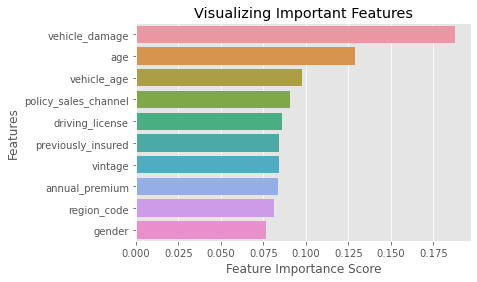

In [27]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(test_data_df.drop('id', axis=1))

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_scores)

sns.barplot(x=feature_scores, y=feature_scores.index)# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()
# cf_matrix = confusion_matrix(y_test['response'], y_pred)
# cf_matrix